## 1. 定义算法

In [1]:
import parl
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
class Actor(parl.Model):
    def __init__(self, n_states, n_actions):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(n_states, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, n_actions)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        return paddle.tanh(self.l3(x))

class Critic(parl.Model):
    def __init__(self, n_states, n_actions):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(n_states, 400)
        self.l2 = nn.Linear(400 + n_actions, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(paddle.concat([x, action], 1)))
        return self.l3(x)
class ActorCritic(parl.Model):
    def __init__(self, n_states, n_actions):
        super(ActorCritic, self).__init__()
        self.actor_model = Actor(n_states, n_actions)
        self.critic_model = Critic(n_states, n_actions)

    def policy(self, state):
        return self.actor_model(state)

    def value(self, state, action):
        return self.critic_model(state, action)

    def get_actor_params(self):
        return self.actor_model.parameters()

    def get_critic_params(self):
        return self.critic_model.parameters()

[09-28 00:38:01 MainThread @utils.py:73] paddlepaddle version: 2.3.2.


In [2]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

In [3]:
import parl
import paddle
import numpy as np


class DDPGAgent(parl.Agent):
    def __init__(self, algorithm,memory,cfg):
        super(DDPGAgent, self).__init__(algorithm)
        self.n_actions = cfg['n_actions']
        self.expl_noise = cfg['expl_noise']
        self.batch_size = cfg['batch_size'] 
        self.memory = memory
        self.alg.sync_target(decay=0)

    def sample_action(self, state):
        action_numpy = self.predict_action(state)
        action_noise = np.random.normal(0, self.expl_noise, size=self.n_actions)
        action = (action_numpy + action_noise).clip(-1, 1)
        return action

    def predict_action(self, state):
        state = paddle.to_tensor(state.reshape(1, -1), dtype='float32')
        action = self.alg.predict(state)
        action_numpy = action.cpu().numpy()[0]
        return action_numpy

    def update(self):
        if len(self.memory) < self.batch_size: 
            return
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        done_batch = np.expand_dims(done_batch , -1)
        reward_batch = np.expand_dims(reward_batch, -1)
        state_batch = paddle.to_tensor(state_batch, dtype='float32')
        action_batch = paddle.to_tensor(action_batch, dtype='float32')
        reward_batch = paddle.to_tensor(reward_batch, dtype='float32')
        next_state_batch = paddle.to_tensor(next_state_batch, dtype='float32')
        done_batch = paddle.to_tensor(done_batch, dtype='float32')
        critic_loss, actor_loss = self.alg.learn(state_batch, action_batch, reward_batch, next_state_batch,
                                                 done_batch)

In [4]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print(f"开始训练！")
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg["train_eps"]):
        ep_reward = 0  
        state = env.reset()  
        for i_step in range(cfg['max_steps']):
            action = agent.sample_action(state) # 采样动作
            next_state, reward, done, _ = env.step(action)  
            agent.memory.push((state, action, reward,next_state, done)) 
            state = next_state  
            agent.update()  
            ep_reward += reward  
            if done:
                break
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    env.close()
    res_dic = {'episodes':range(len(rewards)),'rewards':rewards}
    return res_dic

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg['test_eps']):
        ep_reward = 0  
        state = env.reset()  
        for i_step in range(cfg['max_steps']):
            action = agent.predict_action(state) 
            next_state, reward, done, _ = env.step(action)  
            state = next_state  
            ep_reward += reward 
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    env.close()
    return {'episodes':range(len(rewards)),'rewards':rewards}



In [5]:
import gym
import os
import paddle
import numpy as np
import random
from parl.algorithms import DDPG
class NormalizedActions(gym.ActionWrapper):
    ''' 将action范围重定在[0.1]之间
    '''
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        return action
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    paddle.seed(seed)
def env_agent_config(cfg):
    env = NormalizedActions(gym.make(cfg['env_name'])) # 装饰action噪声
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    print(f"状态维度：{n_states}，动作维度：{n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    memory = ReplayBuffer(cfg['memory_capacity'])
    model = ActorCritic(n_states, n_actions)
    algorithm = DDPG(model, gamma=cfg['gamma'], tau=cfg['tau'], actor_lr=cfg['actor_lr'], critic_lr=cfg['critic_lr'])
    agent = DDPGAgent(algorithm,memory,cfg)
    return env,agent

In [6]:

import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DDPG',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='Pendulum-v0',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=200,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--max_steps',default=100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.99,type=float,help="discounted factor")
    parser.add_argument('--critic_lr',default=1e-3,type=float,help="learning rate of critic")
    parser.add_argument('--actor_lr',default=1e-4,type=float,help="learning rate of actor")
    parser.add_argument('--memory_capacity',default=80000,type=int,help="memory capacity")
    parser.add_argument('--expl_noise',default=0.1,type=float)
    parser.add_argument('--batch_size',default=128,type=int)
    parser.add_argument('--target_update',default=2,type=int)
    parser.add_argument('--tau',default=1e-2,type=float)
    parser.add_argument('--critic_hidden_dim',default=256,type=int)
    parser.add_argument('--actor_hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")  
    parser.add_argument('--seed',default=1,type=int,help="random seed")
    args = parser.parse_args([])    
    args = {**vars(args)} # 将args转换为字典  
    # 打印参数
    print("训练参数如下：")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("参数名","参数值","参数类型"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))                  
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg,path=None,tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()


训练参数如下：
        参数名         	        参数值         	        参数类型        
     algo_name      	        DDPG        	   <class 'str'>    
      env_name      	    Pendulum-v0     	   <class 'str'>    
     train_eps      	        200         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
     max_steps      	       100000       	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
     critic_lr      	       0.001        	  <class 'float'>   
      actor_lr      	       0.0001       	  <class 'float'>   
  memory_capacity   	       80000        	   <class 'int'>    
     expl_noise     	        0.1         	  <class 'float'>   
     batch_size     	        128         	   <class 'int'>    
   target_update    	         2          	   <class 'int'>    
        tau         	        0.01        	  <class 'float'>   
 critic_hidden_dim  	        256         	   <class 'int'>    
  actor_hidden_dim  	        256         	   <c

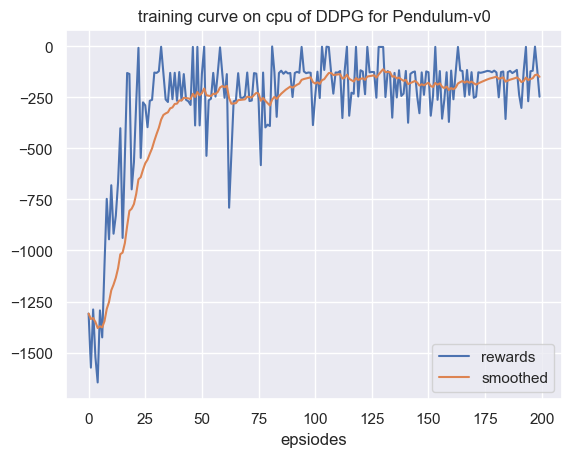

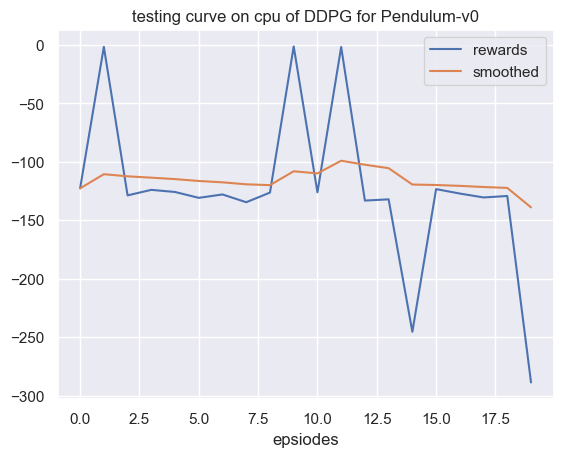

In [7]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果